In [28]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm
# import statistics
import json
# from PIL import Image, ImageDraw, ImageFont
import scipy


In [2]:
def load_H5_bodypart(tracking_path,video_type, tracking_point):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'task' in file:
                back_file = pd.read_hdf(tracking_path + file)     
                
    # drag data out of the df
    scorer = back_file.columns.tolist()[0][0]
    body_part = back_file[scorer][tracking_point]
    
    parts=[]
    for item in list(back_file[scorer]):
        parts+=[item[0]]
    print(np.unique(parts))
    
    # clean and interpolate frames with less than 98% confidence
    clean_and_interpolate(body_part,0.98)
    
    return(body_part)
  
def load_H5_ports(tracking_path,video_type):

    # Load in all '.h5' files for a given folder:
    TFiles_unsort = list_files(tracking_path, 'h5')

    for file in TFiles_unsort:
        print(file)
        if video_type in file:
            if 'port' in file:
                back_ports_file = pd.read_hdf(tracking_path + file)

    ## same for the ports:
    scorer = back_ports_file.columns.tolist()[0][0]
        
    if video_type == 'back':
        port1 =back_ports_file[scorer]['port2']
        port2 =back_ports_file[scorer]['port1']
        port3 =back_ports_file[scorer]['port6']
        port4 =back_ports_file[scorer]['port3']
        port5 =back_ports_file[scorer]['port7']
    else:
        port1 =back_ports_file[scorer]['Port2']
        port2 =back_ports_file[scorer]['Port1']
        port3 =back_ports_file[scorer]['Port6']
        port4 =back_ports_file[scorer]['Port3']
        port5 =back_ports_file[scorer]['Port7']

    clean_and_interpolate(port1,0.98)
    clean_and_interpolate(port2,0.98)
    clean_and_interpolate(port3,0.98)
    clean_and_interpolate(port4,0.98)
    clean_and_interpolate(port5,0.98)
    
    return(port1,port2,port3,port4,port5)

def list_files(directory, extension):
    return (f for f in os.listdir(directory) if f.endswith('.' + extension))

def clean_and_interpolate(head_centre,threshold):
    bad_confidence_inds = np.where(head_centre.likelihood.values<threshold)[0]
    newx = head_centre.x.values
    newx[bad_confidence_inds] = 0
    newy = head_centre.y.values
    newy[bad_confidence_inds] = 0

    start_value_cleanup(newx)
    interped_x = interp_0_coords(newx)

    start_value_cleanup(newy)
    interped_y = interp_0_coords(newy)
    
    head_centre['interped_x'] = interped_x
    head_centre['interped_y'] = interped_y
    
def start_value_cleanup(coords):
    # This is for when the starting value of the coords == 0; interpolation will not work on these coords until the first 0 
    #is changed. The 0 value is changed to the first non-zero value in the coords lists
    for index, value in enumerate(coords):
        working = 0
        if value > 0:
            start_value = value
            start_index = index
            working = 1
            break
    if working == 1:
        for x in range(start_index):
            coords[x] = start_value
            
def interp_0_coords(coords_list):
    #coords_list is one if the outputs of the get_x_y_data = a list of co-ordinate points
    for index, value in enumerate(coords_list):
        if value == 0:
            if coords_list[index-1] > 0:
                value_before = coords_list[index-1]
                interp_start_index = index-1
                #print('interp_start_index: ', interp_start_index)
                #print('interp_start_value: ', value_before)
                #print('')

        if index < len(coords_list)-1:
            if value ==0:
                if coords_list[index+1] > 0:
                    interp_end_index = index+1
                    value_after = coords_list[index+1]
                    #print('interp_end_index: ', interp_end_index)
                    #print('interp_end_value: ', value_after)
                    #print('')

                    #now code to interpolate over the values
                    try:
                        interp_diff_index = interp_end_index - interp_start_index
                    except UnboundLocalError:
#                         print('the first value in list is 0, use the function start_value_cleanup to fix')
                        break
                    #print('interp_diff_index is:', interp_diff_index)

                    new_values = np.linspace(value_before, value_after, interp_diff_index)
                    #print(new_values)

                    interp_index = interp_start_index+1
                    for x in range(interp_diff_index):
                        #print('interp_index is:', interp_index)
                        #print('new_value should be:', new_values[x])
                        coords_list[interp_index] = new_values[x]
                        interp_index +=1
        if index == len(coords_list)-1:
            if value ==0:
                for x in range(30):
                    coords_list[index-x] = coords_list[index-30]
                    #print('')
#     print('function exiting')
    return(coords_list)

def sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=None, th=0.2):
    ## this is number of neurons in total
    N_neurons= bkgd_log_proportions_array.shape[1]
    ## number of sequences from json file 
    n_sequences = config["num_sequence_types"]
    # the 18 neuron params for each neuron from the last iteration
    all_final_globals = neuron_response_df.iloc[-N_neurons:]
    # this cuts it down to just the first 6 params - i think this correspond sto the first param for each seq type? response probABILITY - ie the chance that a neuron spikes in a given latent seq 
    resp_prop = np.exp(all_final_globals.values[:, :n_sequences])#
    # this takes the next 6 params - which i think are the offset values
    offset = all_final_globals.values[-N_neurons:, n_sequences:2*n_sequences]
    ## finds the max response value - ie. which seq it fits to? 
    peak_response = np.amax(resp_prop, axis=1)
    # then threshold the reponse
    has_response = peak_response > np.quantile(peak_response, th)
    # I thin this is the sequence that the neuron has the max response for: ie. we are ordering them by max response 
    preferred_type = np.argmax(resp_prop, axis=1)
    if sequence_ordering is None:
        # order them by max reponse 
        ordered_preferred_type = preferred_type
    else:
        #order them differnetly 
        ordered_preferred_type = np.zeros(N_neurons)#
        # loop through each sequence
        for seq in range(n_sequences):
            # where does  max repsone = user defined seque
            seq_indices = np.where(preferred_type == sequence_ordering[seq])
            # change order to different seq
            ordered_preferred_type[seq_indices] = seq

    # reorder the offset params according to max respsone
    preferred_delay = offset[np.arange(N_neurons), preferred_type]
    Z = np.stack([has_response, ordered_preferred_type+1, preferred_delay], axis=1)
    indexes = np.lexsort((Z[:, 2], Z[:, 1], Z[:, 0]))
    return indexes,ordered_preferred_type

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def split_list(nums):
    sublists = []
    current_sublist = [nums[0]]
    current_element = nums[0]
    for i in range(1,len(nums)):
        if nums[i] == current_element:
            current_sublist.append(nums[i])
        else:
            sublists.append(current_sublist)
            current_sublist = [nums[i]]
            current_element = nums[i]
    sublists.append(current_sublist)
    return sublists

def merge_short_blocks(lst,threshold):
    merged_list = []
    current_block = [lst[0]]

    for i in range(1, len(lst)):
        if lst[i] == lst[i-1]:
            current_block.append(lst[i])
        else:
            if len(current_block) < threshold:
                if len(merged_list) > 0:
                    # Join with smallest adjacent block
                    if len(current_block) <= len(merged_list[-1]):
                        merged_list[-1].extend(current_block)
                    else:
                        merged_list.append(current_block + merged_list.pop())
                else:
                    # No adjacent block, discard current block
                    pass
            else:
                merged_list.append(current_block)
            
            current_block = [lst[i]]

    # Check the last block
    if len(current_block) < 3:
        if len(merged_list) > 0:
            if len(current_block) <= len(merged_list[-1]):
                merged_list[-1].extend(current_block)
            else:
                merged_list.append(current_block + merged_list.pop())
        else:
            pass
    else:
        merged_list.append(current_block)
        
    out = []
    for item in merged_list:
        out += [item[0]] * len(item)
        

    return out

def relabel_list(lst):
    # Create a dictionary to map original values to new labels
    label_dict = {}
    new_label = 1

    # Iterate over the list and assign new labels
    relabeled_list = []
    for value in lst:
        if value not in label_dict:
            label_dict[value] = new_label
            new_label += 1
        relabeled_list.append(label_dict[value])

    return relabeled_list



yellow = '#E2DC92'
green = '#69BD9D'
blue = '#1C79B5'
red = '#BE575F'
dark_blue = '#264999'
purple = '#724F94'
gold = '#C6963E'


In [3]:
mouse_session_recording = '178_1_7'
region = 'striatum'
type_ = 'long_awake'
## PATHS
PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
# PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\output_data\old_data_filter_method\striatum\awake\\"
DAT_PATH = r"Z:\projects\sequence_squad\organised_data\animals\\"



## set ppseq file
for file_ in os.listdir(PP_PATH):
    if mouse_session_recording in file_:
        file = file_
        
save_path = PP_PATH + file + '\\analysis_output\\'
        
## set dat_path:
for file_ in os.listdir(DAT_PATH):
    if mouse_session_recording.split('_')[0] in file_:
        if mouse_session_recording.split('_')[1] == file_[-1]:
            dat_path = os.path.join(DAT_PATH,file_)
for recording in os.listdir(os.path.join(DAT_PATH,dat_path)):
    if recording.split('_')[0][9::] == mouse_session_recording.split('_')[-1]:
        dat_path = os.path.join(dat_path,recording)
        
# set tracking path
for file_ in os.listdir(dat_path + r"\video\tracking\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
# set video paths
for file_ in os.listdir(dat_path + r"\video\videos\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            cam_path = os.path.join(dat_path + r"\video\videos\\",file_) + '\\' 
            for vid_file in os.listdir(cam_path):
                if 'back' in vid_file and '.avi' in vid_file:
                    back_cam_avi_path = os.path.join(cam_path,vid_file)
                if 'side' in vid_file and '.avi' in vid_file:
                    side_cam_avi_path = os.path.join(cam_path,vid_file)

In [4]:

print('\n')
print("LOADING processed_spike_data")
### load in releavent things:

import pickle
with open(PP_PATH + file + "\\analysis_output\\" + "latent_event_history_df_split.pickle", "rb") as input_file:
    latent_event_history_df_split = pickle.load(input_file)
    
with open(PP_PATH + file + "\\analysis_output\\" + "spikes_seq_type_adjusted.pickle", "rb") as input_file:
    spikes_seq_type_adjusted = pickle.load(input_file)
    
neuron_order = np.load(PP_PATH + file + "\\analysis_output\\" + 'neuron_order.npy')

ordered_preferred_type = np.load(PP_PATH + file + "\\analysis_output\\" + 'ordered_preferred_type.npy')

neuron_index = np.load(PP_PATH + file + "\\analysis_output\\" + 'neuron_index.npy')



# Opening JSON file
f = open(PP_PATH + file + r'\config_file.json')
# returns JSON object as a dictionary
config = eval(json.load(f))


##### load deeplabcut tracking data
print('\n')
print("LOADING DLC TRACKING DATA")
back_head_centre = load_H5_bodypart(tracking_path,'back','head_centre')
back_p1,back_p2,back_p3,back_p4,back_p5 = load_H5_ports(tracking_path,'back')


## load in the timespan used for pppseq:
input_params_path = os.path.join(PP_PATH + file,'trainingData\\') + ('params_' + mouse_session_recording +'.json')
# Opening JSON file
f = open(input_params_path)
# returns JSON object as  a dictionary
input_config = json.load(f)
behav_time_interval_start = input_config['time_span'][0]
print(f"      A corresponding time span has been found. Time span set to {behav_time_interval_start}")


## LOAD behaviour data
print('\n')
print("LOADING BEHAV DATA")
behav_sync = pd.read_csv(dat_path + r'\behav_sync\2_task\Behav_Ephys_Camera_Sync.csv')
transitions = pd.read_csv(dat_path + r'\behav_sync\2_task\Transition_data_sync.csv')

behav_mask = (behav_sync.PokeIN_EphysTime>behav_time_interval_start[0])*(behav_sync.PokeIN_EphysTime<behav_time_interval_start[1])
poke_in_times = (behav_sync[behav_mask].PokeIN_EphysTime) - behav_time_interval_start[0]
ports = behav_sync[behav_mask].Port
print('done')



LOADING processed_spike_data


LOADING DLC TRACKING DATA
back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5
back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5
side_2022-03-30T15_02_32DLC_resnet50_port-tracking_side-viewApr29shuffle1_700000.h5
side_2022-03-30T15_02_32DLC_resnet50_task-tracking-sideviewApr15shuffle1_670000.h5
['head_centre' 'implant_centre' 'left_ear' 'right_ear' 'tail_base']
back_2022-03-30T15_02_32DLC_resnet50_port-tracking_back_viewMay2shuffle1_500000.h5
back_2022-03-30T15_02_32DLC_resnet50_task-tracking_backviewApr6shuffle1_800000.h5
side_2022-03-30T15_02_32DLC_resnet50_port-tracking_side-viewApr29shuffle1_700000.h5
side_2022-03-30T15_02_32DLC_resnet50_task-tracking-sideviewApr15shuffle1_670000.h5
      A corresponding time span has been found. Time span set to [5400, 6000]


LOADING BEHAV DATA
done


In [5]:
## load some stuff 
neuron_response_df = pd.read_csv(PP_PATH + file + r"\neuron_response.csv")
bkgd_log_proportions_array = pd.read_csv(PP_PATH + file + r"\bkgd_log_proportions_array.csv")


# recolor and save these plots out

current_color_order = [purple, blue, red, gold, yellow, green]
# current_color_order = [yellow, red, blue, green, gold, purple]

# current_color_order = [red, yellow, green, blue,gold, purple]

# current_color_order = [blue,purple,gold,green,red,yellow]


colors = ['---',red,green,yellow,blue,purple,gold,dark_blue]
# ## recolor based on current and desired color order

new_order_inds = [0]
for item in current_color_order:
    new_order_inds += [np.where(np.array(colors) == item)[0][0]]

# apply this ordering
new_colors = colors.copy()
for i,index in enumerate(new_order_inds):
    colors[index] = new_colors[i]                     
                       
# determine new ordering based on this as well
ordering = list((np.array(new_order_inds)-1)[np.array(new_order_inds)-1 >=0])
#swap last 'extra' seq down to the bottom 
ordering = [ordering[-1]] + ordering[0:-1]

print(ordering)




########### IF ORDERING DOESNT WORK DO IT MANUALLY: ######

# ordering = [ 0, 5, ,4, 3, 2,1]






## neuron order:

#define neuron order
neuron_index,ordered_preferred_type = sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=ordering)
# make a list of idndies for each neurons new position
neuron_permute_loc = np.zeros(len(neuron_index))
for i in range(len(neuron_index)):
    neuron_permute_loc[i] = int(list(neuron_index).index(i))
new_neuron_order = neuron_permute_loc[spikes_seq_type_adjusted.neuron.values.astype(int)-1]



[1, 4, 3, 0, 5, 2]


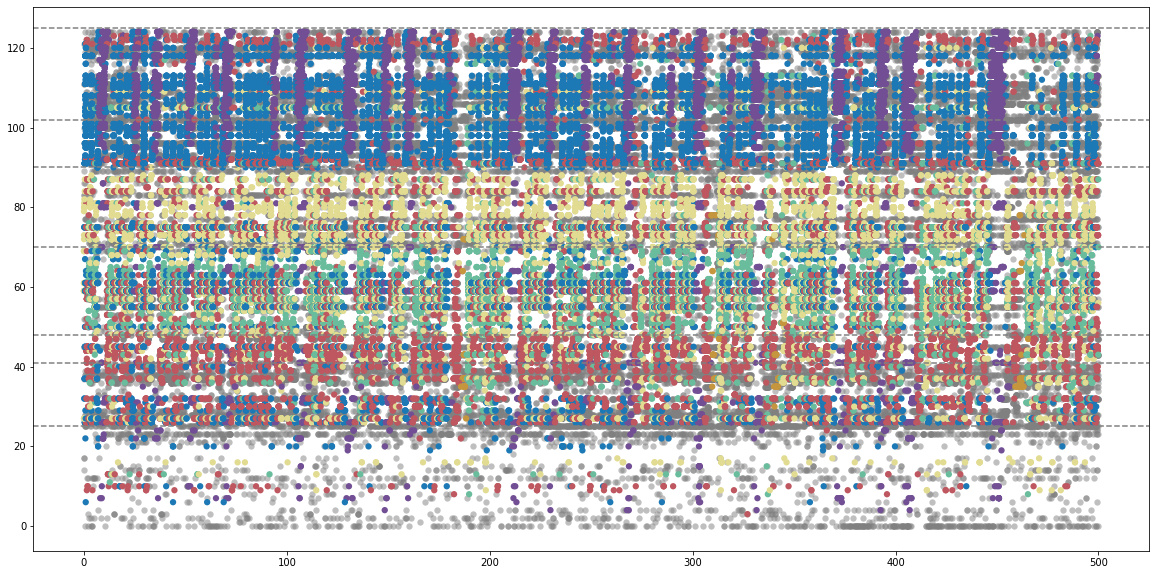

In [6]:
### Plot sequences - basic
timeframe = [0,500]
mask = (spikes_seq_type_adjusted.timestamp>timeframe[0])*(spikes_seq_type_adjusted.timestamp<timeframe[-1])


## plotting:

fig, ax = plt.subplots(1, 1,figsize=(20, 10))

#'#FF000000' is transparent
# colors = ['---','brown','red','blue','purple','orange','green','#FF000000']
    
# plot background in grey 
background_keep_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted <= 0
ax.scatter(spikes_seq_type_adjusted[mask][background_keep_mask].timestamp, new_neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)

# plot spikes without background
background_remove_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted >= 0
c_ = np.array(colors)[spikes_seq_type_adjusted[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
# ## faster:
ax.scatter(spikes_seq_type_adjusted[mask][background_remove_mask].timestamp, new_neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)

### add chunk lines:

## work out ordering chunk sizes
split_lists = split_list(ordered_preferred_type[neuron_index])
lens = []
for list_ in split_lists:
    lens += [len(list_)]
chunks = [sum(lens[0:int(np.unique(ordered_preferred_type)[-1]+1)])] + lens[int(np.unique(ordered_preferred_type)[-1]+1)::] 

## plot seq divding lines:
for i in range(len(chunks)):
    ax.axhline(y = np.cumsum(chunks)[i], color = 'grey', linestyle = '--')


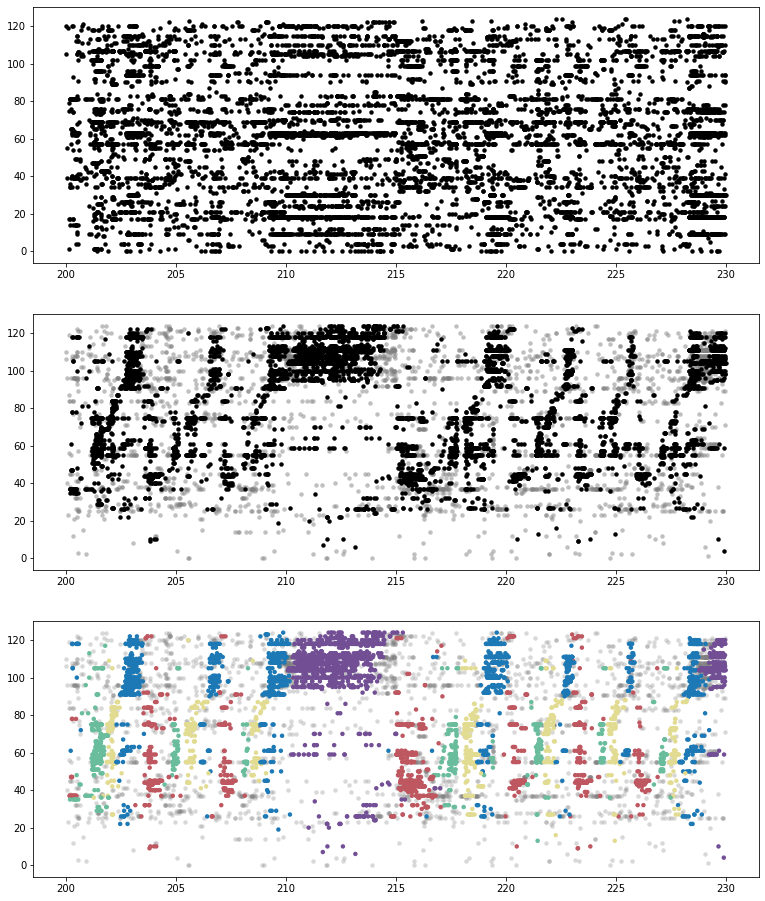

In [7]:
import random

def shuffle(aList):
    random.shuffle(aList)
    return aList

### Plot sequences - basic
timeframe = [200,230]

mask = (spikes_seq_type_adjusted.timestamp>timeframe[0])*(spikes_seq_type_adjusted.timestamp<timeframe[-1])

## neuron order:

#define neuron order
neuron_index,ordered_preferred_type = sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=ordering)
# make a list of idndies for each neurons new position
neuron_permute_loc = np.zeros(len(neuron_index))
for i in range(len(neuron_index)):
    neuron_permute_loc[i] = int(list(neuron_index).index(i))
    
neuron_permute_loc = np.array(shuffle(list(neuron_permute_loc.astype(int))))
neuron_order = neuron_permute_loc[spikes_seq_type_adjusted.neuron.values.astype(int)-1]

## plotting:
nrow = 3 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(13, 16))

for ind, ax in enumerate(fig.axes):
    
    if ind == 0:
        # plot background in grey 
        background_keep_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted <= 0
        ax.scatter(spikes_seq_type_adjusted[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'k' ,alpha=1)

        # plot spikes without background
        background_remove_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[spikes_seq_type_adjusted[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
        # ## faster:
        ax.scatter(spikes_seq_type_adjusted[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = 'k' ,alpha=1)
        
    if ind == 1:
        
        #define neuron order
        neuron_index,ordered_preferred_type = sortperm_neurons(bkgd_log_proportions_array,config,neuron_response_df, sequence_ordering=ordering)
        # make a list of idndies for each neurons new position
        neuron_permute_loc = np.zeros(len(neuron_index))
        for i in range(len(neuron_index)):
            neuron_permute_loc[i] = int(list(neuron_index).index(i))
#         neuron_order = neuron_permute_loc[unmasked_spikes_df.neuron-1]
        neuron_order = neuron_permute_loc[spikes_seq_type_adjusted.neuron.values.astype(int)-1]

        # plot background in grey 
        background_keep_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted <= 0
        ax.scatter(spikes_seq_type_adjusted[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'grey' ,alpha=0.5)

        # plot spikes without background
        background_remove_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[spikes_seq_type_adjusted[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
        # ## faster:
        ax.scatter(spikes_seq_type_adjusted[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = 'k' ,alpha=1)
        
    if ind == 2:
        
        # plot background in grey 
        background_keep_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted <= 0
        ax.scatter(spikes_seq_type_adjusted[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'grey' ,alpha=0.3)

        # plot spikes without background
        background_remove_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[spikes_seq_type_adjusted[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
        # ## faster:
        ax.scatter(spikes_seq_type_adjusted[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = c_ ,alpha=1)


    

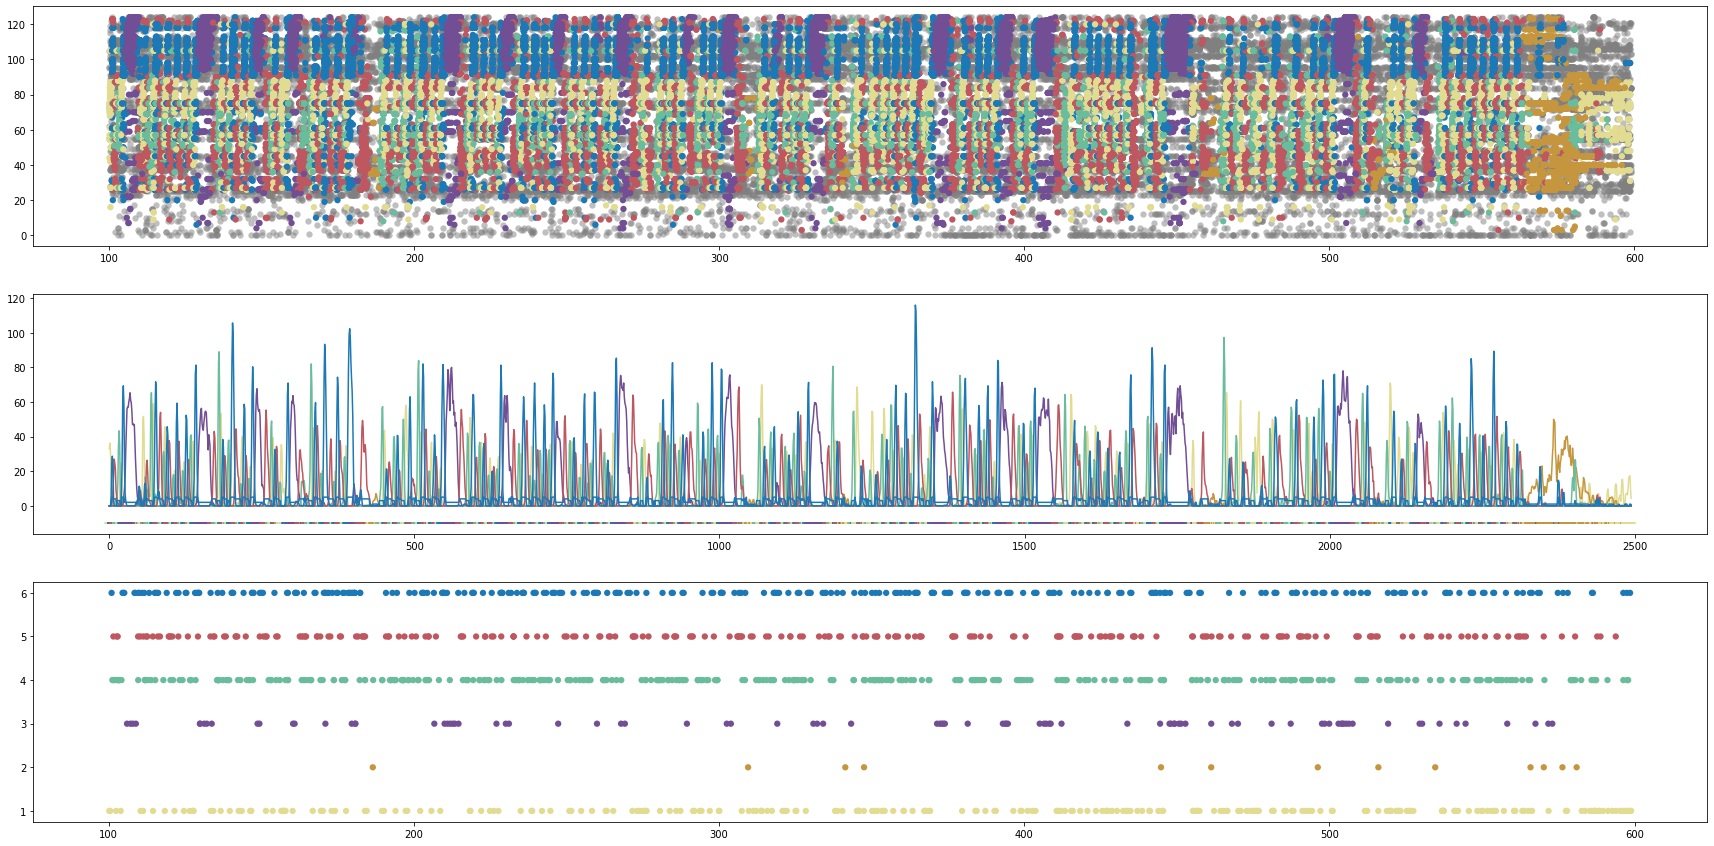

In [8]:
timeframe = [100,599]

#mask
# spikemask
mask = (spikes_seq_type_adjusted.timestamp>timeframe[0])*(spikes_seq_type_adjusted.timestamp<timeframe[-1])

fig, [ax1,ax2,ax3] = plt.subplots(3, 1,figsize=(30, 15))

1 ### plot ordered ppseq spikes as above:

# plot background in grey 
background_keep_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted <= 0
ax1.scatter(spikes_seq_type_adjusted[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=40, linewidth=0,color = 'grey' ,alpha=0.5)
# mask to remove background neurons from the color plot
background_remove_mask = spikes_seq_type_adjusted[mask].sequence_type_adjusted >= 0
c_ = np.array(colors)[spikes_seq_type_adjusted[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
ax1.scatter(spikes_seq_type_adjusted[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)


### bin the spiking and plot number of spikes for each seq type
seqs = np.unique(spikes_seq_type_adjusted.sequence_type_adjusted)
seq_spikes = []
for seq_type_ in seqs:  
    seq_spikes += [spikes_seq_type_adjusted.timestamp[np.where(spikes_seq_type_adjusted.sequence_type_adjusted ==seq_type_)[0]].values]

# Define the bin size (in this case, 0.2s)
bin_size = 0.2

seq_spike_occurance = []
for spikes_ in seq_spikes:
    # Use the numpy.histogram function to bin the data
    hist, bins = np.histogram(spikes_, bins=np.arange(0, np.diff(behav_time_interval_start)[0], bin_size))
    seq_spike_occurance += [list(hist)]
    
strt_ = int(timeframe[0]/bin_size)
end_ = int(timeframe[1]/bin_size)

for i in range (1,len(seq_spike_occurance)):
#     ax2.plot(seq_spike_occurance[i][strt_:end_], c = colors[i])
    ax2.plot(convolve_movmean(seq_spike_occurance[i][strt_:end_],3), c = colors[i])
    

## plot the current seq type (based on binned spiking):
nth_vectors = conactinate_nth_items(seq_spike_occurance[1::])
max_index= []
max_index += [np.argmax(sublist) for sublist in nth_vectors] 

ax2.plot(max_index[strt_:end_])

ax2.scatter(np.linspace(0,end_ - strt_-1,end_ - strt_),np.ones(end_ - strt_)*-10, marker = '_',color = np.array(colors)[np.array(max_index)+1][strt_:end_], s = 100)

### plot the ppseq latent:

# mask for the timespan
latent_timespan_mask = (latent_event_history_df_split.timestamp>timeframe[0])*(latent_event_history_df_split.timestamp<timeframe[-1])

# ignore anything that is below threshold * max amplitude
thr_ = 0
thresh_value = max(latent_event_history_df_split.amplitude) * thr_


amplitude_mask = latent_event_history_df_split[latent_timespan_mask].amplitude > thresh_value

c_l = np.array(colors)[latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type.values.astype(int)]
ax3.scatter(latent_event_history_df_split[latent_timespan_mask][amplitude_mask].timestamp,latent_event_history_df_split[latent_timespan_mask][amplitude_mask].seq_type ,marker = 'o', s=40, linewidth=0,color = c_l ,alpha=1)


Text(0.5, 1.0, 'timeframe = [100, 599]')

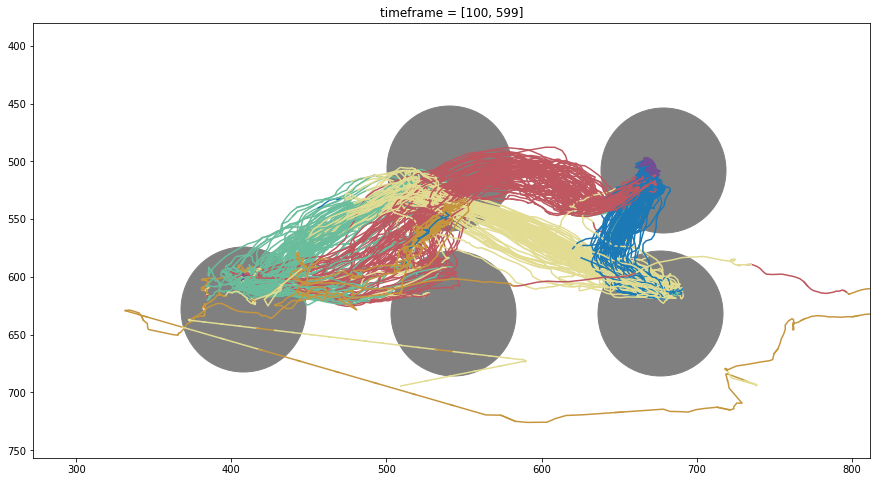

In [9]:
fps = 60
# behav_mask
mask_ = (poke_in_times > timeframe[0]) * (poke_in_times < timeframe[1])

# tracking and ehys times are synced to poke in times so tracking position has to be aligned to first poke in time in this timeframe. 

# Find the difference between PokeIN_EphysTime and the start of the behavior interval
interval_pokeIn_spike_times = behav_sync.PokeIN_EphysTime[behav_mask][mask_].values - behav_time_interval_start[0]
# Find the offset between the first poke in time and the start of the timeframe
tracking_offset = interval_pokeIn_spike_times[0] - timeframe[0]

# Get the first synced time for the camera in the interval 
interval_cam_times =  behav_sync.backcam_aligned_pokein_times[behav_mask][mask_].values[0]
# Align the tracking start with the ephys by subtracting the offset
cam_start_time = interval_cam_times - tracking_offset

# Calculate the number of events based on the timeframe size and bin size
events = np.diff(timeframe)[0] /bin_size 
# Create a list for start times, with the first start time being the camera start time converted to timestamps - 60fps
start_ts = [cam_start_time * fps]
# Convert the bin size to timestamps - 60fps
bin_ts = bin_size * fps

# Create an empty list for end times
end_ts = []
# Loop through the number of events
for i in range(int(events)):
    # If it is not the first event, set the start time as the end time of the previous event
    if i > 0:
        start_ts += [end_ts[i-1]]
    # Add the current start time plus the bin size to the list of end times
    end_ts += [start_ts[i] + bin_ts] 

    
    
nrow = 1 
ncol = 1
fig, axs = plt.subplots(nrow, ncol,figsize=(15, 8))

for ind, ax in enumerate(fig.axes):
    for item in [back_p1,back_p2,back_p3,back_p4,back_p5]:
        ax.plot(np.median(item['interped_x'].values),np.median(item['interped_y'].values),'o',color = 'grey', markersize = 125)
    for i in range(int(events)):
        ax.plot(back_head_centre['interped_x'].values[int(start_ts[i])-1:int(end_ts[i])+1],back_head_centre['interped_y'].values[int(start_ts[i])-1:int(end_ts[i])+1],'-',color =  np.array(colors)[np.array(max_index)+1][strt_:end_][i], alpha = 1)
#         ax.plot(back_head_centre['interped_x'].values[int(start_ts[i])-1:int(end_ts[i])+1],back_head_centre['interped_y'].values[int(start_ts[i])-1:int(end_ts[i])+1],'-',color = color_gradients[i])
                
    

        
    min_x = np.median(back_p2['interped_x'].values) - (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    max_x = np.median(back_p4['interped_x'].values) + (np.median(back_p1['interped_x'].values) - np.median(back_p2['interped_x'].values))
    min_y = np.median(back_p3['interped_y'].values) - (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    max_y = np.median(back_p1['interped_y'].values) + (np.median(back_p1['interped_y'].values) - np.median(back_p3['interped_y'].values))
    ax.set_xlim(min_x,max_x)
    ax.set_ylim(min_y,max_y)

    ax.invert_yaxis()
    
ax.set_title('timeframe = ' + str(timeframe))
    

    

178_1_7


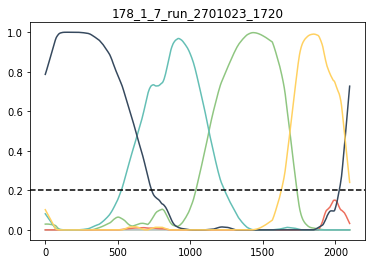

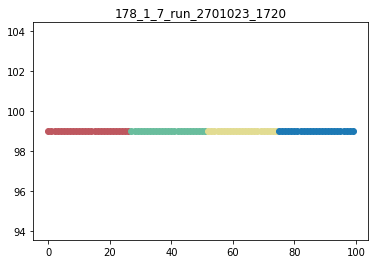

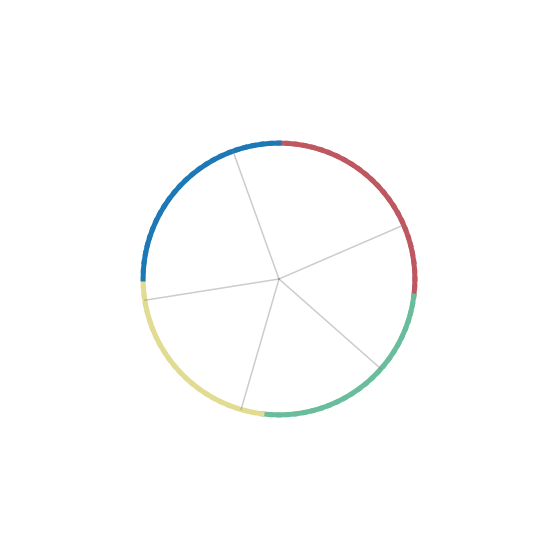

In [10]:
awake_PP_path = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"

color_all= []
relabeled_lists= []
animals = [] 
# ignore those that are during learning:

list_ = ["178_1_7"] 

for index_,M_I_R in enumerate(os.listdir(awake_PP_path)):
    
    if not M_I_R == 'not_suitable':
    
        mouse = '_'.join(M_I_R.split('_')[0:3])

        if mouse in list_:
            print(mouse)

        #     M_I_R = '178_1_7_run_2701023_1720'
            c_path = awake_PP_path + M_I_R + r"\analysis_output\reordered_recolored\\"  
        #     seq_occurances_df = pd.read_csv((c_path+'binned_seq_occurance_df.csv'))

        #     overlap_positions_standard_space = np.load(c_path+ '/overlap_positions_standard_space.npy',allow_pickle = True)

            with open(os.path.join(c_path,"colors"), "rb") as input_file:
                colors = pickle.load(input_file)

            warped_x = np.load(c_path+ 'fixed_standard_space\warped_x.npy',allow_pickle = True)

            smoothed_counts = np.load(c_path+ 'fixed_standard_space\smoothed_counts.npy',allow_pickle = True)


            from itertools import groupby

            total_smoothed_counts = np.array(smoothed_counts).sum(axis=0)

            fig, ax = plt.subplots()
            for i in range(6):
                ax.plot(convolve_movmean(smoothed_counts[i]/total_smoothed_counts,100), color = colors[i+1])   
            ax.set_title(M_I_R)
            
#             if mouse == '178_1_7':
#                 SaveFig('example_dominance_plot.pdf',r'Z:\projects\Emmett\Documents\writeup\fig4_PPseq\\')
                

            # determine threshold
            threshold = 0.2


            plt.axhline(threshold, color='k', linestyle='--')


            overlap_positions_standard_space = []
            overlap_positions = []

            # overlaps with short bouts   
            overlap_color = []


            for seq in range(6):
                over_thr_mask = (np.array(smoothed_counts[seq])/total_smoothed_counts) > threshold # 20% of the activity is explained by this motif

                # get rid of short isolated motifs
                c = 0
                split_motifs = groupby(over_thr_mask)
                start_over_thr = False
                for over_thr, points in split_motifs:
                    if c==0 and over_thr==True: # keep in mind if a fragment of the motif starts from the beginning of the trial 
                        start_over_thr = True 
                    points = list(points)
                    if over_thr==True: # fragment of motif over threshold (over the threshold)
                        if len(points) < 10 and c+len(points)<len(over_thr_mask): # too short and not at the extremity
                            over_thr_mask[c:c+len(points)] = False # do not count them as a relevant motif
                            change_made = True
                        elif len(points) < 10 and not(start_over_thr): # too short at the right extremity but not at the left extremity
                            over_thr_mask[c:c+len(points)] = False # do not count them as a relevant motif 
                            change_made = True
                    c += len(points)
                overlap_color.append(over_thr_mask)

                overlap_positions += [list(np.linspace(0,len(smoothed_counts[0])-1,len(smoothed_counts[0]))[overlap_color[seq]].astype(int))]

                ###  convert to standard space:
                overlap_positions_standard_space += [list(np.linspace(0,len(smoothed_counts[0])-1,len(smoothed_counts[0]))[overlap_color[seq]] / len(overlap_color[seq]) * 100)]


            v_smoothed_counts= []
            for i in range(len(smoothed_counts)):
                v_smoothed_counts += [convolve_movmean(smoothed_counts[i]/total_smoothed_counts,100)]
            dominant = []
            for bin_ in conactinate_nth_items(v_smoothed_counts):
                dominant += [np.argmax(bin_)+1]


            def most_common(lst):
                return max(set(lst), key=lst.count)

            comprssed_to_hundred_bins = []
            for i in range(100):
                comprssed_to_hundred_bins +=[most_common(list(np.array(dominant)[(warped_x >= i) * (warped_x <= i+1)]))]
            color_ = np.array(colors)[comprssed_to_hundred_bins]
            

            new_color_order_for_nice_plotting = ['spacer','#BE575F','#69BD9D','#E2DC92','#1C79B5', '#724F94','#C6963E']

            # covert colors back into numbers :
            seq_type = []
            for i in range(len(color_)):
                index = colors.index(color_[i])
                seq_type += [index]
                
            # hacky fix for weird error:
            if mouse == '149_1_2':
                seq_type= [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6]
            if mouse == '268_1_10':
                seq_type = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
            
            # remove very short blocks ()
            result = merge_short_blocks(seq_type,5)

            relabeled_list = relabel_list(result)

            new_nice_plotting_color_order = np.array(new_color_order_for_nice_plotting)[relabeled_list]



            fig, ax = plt.subplots()
            for index,point in enumerate(new_nice_plotting_color_order):
                ax.plot(index,i,'o',color = point)
            ax.set_title(M_I_R)
            
#             if mouse == '178_1_7':
#                 SaveFig('example_dominance_plot_lines.pdf',r'Z:\projects\Emmett\Documents\writeup\fig4_PPseq\\')
                
            
#             color_all += [color_]
            relabeled_lists += [relabeled_list]
            color_all += [new_nice_plotting_color_order]
            animals += [mouse]
                
#             break

x_positions = [18, 36, 54, 72, 94]
rotation_angle = 90  # Rotation angle in degrees

num_rings = 1  # Number of rings
num_segments = 100  # Number of segments in each ring

# Convert rotation angle to radians
rotation_angle_rad = np.deg2rad(rotation_angle)

# Create rotation matrix
rotation_matrix = np.array([
    [np.cos(rotation_angle_rad), -np.sin(rotation_angle_rad)],
    [np.sin(rotation_angle_rad), np.cos(rotation_angle_rad)]
])

# Create figure and axes
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')

# Plot rings
for i in range(num_rings):
    radius = i + 1  # Radius of the ring
    theta = np.linspace(0, 2 * np.pi, num_segments + 1)
    segment_length = 2 * np.pi / num_segments
    mark = (i == num_rings - 1)

    # Plot each segment in the ring
    for j in range(num_segments):
        start_angle = j * segment_length
        end_angle = (j + 1) * segment_length

        x_start, y_start = radius * np.cos(start_angle), radius * np.sin(start_angle)
        x_end, y_end = radius * np.cos(end_angle), radius * np.sin(end_angle)

        # Apply rotation to the start and end points
        start_rotated = np.dot(rotation_matrix, np.array([x_start, y_start]))
        end_rotated = np.dot(rotation_matrix, np.array([x_end, y_end]))

        ax.plot([start_rotated[0], end_rotated[0]], [start_rotated[1], end_rotated[1]], color=color_all[i][j], linewidth=5)

        # Add lines through specified positions on the last ring
        if mark and j in x_positions:
            bisect_x = (start_rotated[0] + end_rotated[0]) / 2
            bisect_y = (start_rotated[1] + end_rotated[1]) / 2
            ax.plot([0, bisect_x], [0, bisect_y], '-', color='grey', alpha=0.4)

# Set plot limits and remove axes
ax.set_xlim(-(num_rings + 1), num_rings + 1)
ax.set_ylim(-(num_rings + 1), num_rings + 1)
ax.axis('off')

# Invert x-axis
ax.invert_xaxis()

Text(0.5, 117.6, 'Start motif')

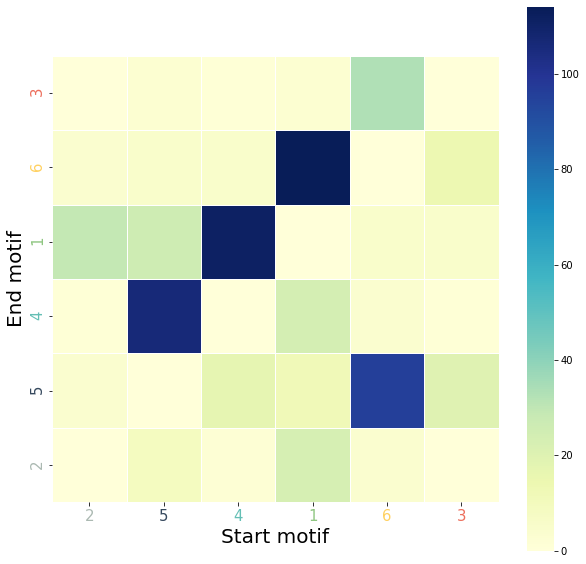

In [11]:
import seaborn as sns; 

def remove_neighboring_duplicates(nums):
    new_list = []
    for i in range(len(nums)):
        if i == 0 or nums[i] != nums[i-1]:
            new_list.append(nums[i])
    return new_list

def create_pairs(nums):
    return [nums[i]*10+nums[i+1] for i in range(len(nums)-1)]

def determineTransitionNumber(TimeFiltered_seqs,possible_transitions):
    TransitionTypesIndex = possible_transitions
    trajects = []
    for ind, transits in enumerate(TimeFiltered_seqs):
        trajects = np.append(trajects,transits)
    transition_number = []
    for transit_types in TransitionTypesIndex:
        temp = (np.where(trajects == float(transit_types)))
        transition_number.append(len(temp[0]))
    return transition_number




# remove repeats
clean_seqs = remove_neighboring_duplicates(max_index)
# clean_seqs= max_index

possible_transitions = [list((np.unique(clean_seqs)+1)+10)]
for i in range(len(np.unique(clean_seqs))):
    if i > 0:
        possible_transitions += [list(np.array(possible_transitions[i-1]) + 10)]
possible_transitions = [item for sublist in possible_transitions for item in sublist]


# add one to these because dealing with 0-num transitions is difficult and then turn them into 'transition' pairs 
transit_pairs = create_pairs(np.array(clean_seqs)+1)

transition_number = determineTransitionNumber(transit_pairs,possible_transitions)

transitions_shaped = np.reshape(transition_number,(6,6))

# Reorder the array base don ordering defined earlier 
reordered_array = transitions_shaped[ordering]
reordered_array = reordered_array[:,ordering]
reordered_array = reordered_array.T[::-1]


order_strings = [str(num) for num in list(np.array(ordering) +1)]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
h1 = sns.heatmap(reordered_array, linewidths=.5,xticklabels= order_strings, yticklabels=order_strings[::-1], square=True,cmap="YlGnBu",fmt = '',cbar_kws = dict(use_gridspec=False,location="right"))

# color labels by motif/seq colour
for i, tick_label in enumerate(ax.axes.get_yticklabels()):
    tick_label.set_color(colors[ordering[::-1][i]+1])
    tick_label.set_fontsize("15")
for i, tick_label in enumerate(ax.axes.get_xticklabels()):
    tick_label.set_color(colors[ordering[i]+1])
    tick_label.set_fontsize("15")
    
    
ax.set_ylabel('End motif',size = 20)
ax.set_xlabel('Start motif',size = 20)


# SaveFig('transition_histogram.png',save_path + 'reordered_recolored\\')

In [26]:
logical_order = np.load(r'Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\178_1_7_run_2701023_1720\analysis_output\latent_composition_analysis\\logical_order.npy')

def return_inds_for_seq_groups(lst):
    groups = []
    new = True
    for ind,item in enumerate(lst):
        if new:
            if item > 0:
                start = ind
                new = False
        else:
            if item == 0:
                end = ind-1
                groups.append((start, end))
                new = True
    return groups

def calculate_percentages(numbers):
    total = sum(numbers)
    percentages = [(number/total) * 100 for number in numbers]
    return percentages




1
3
4
5
6


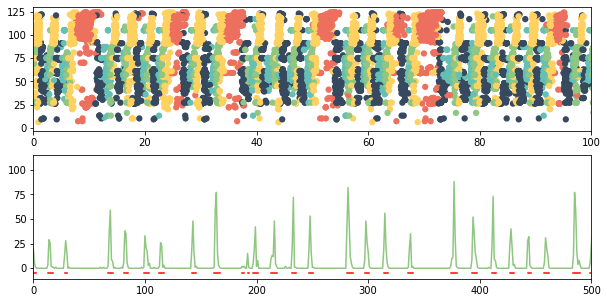

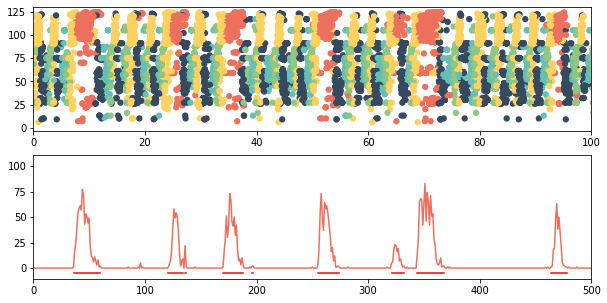

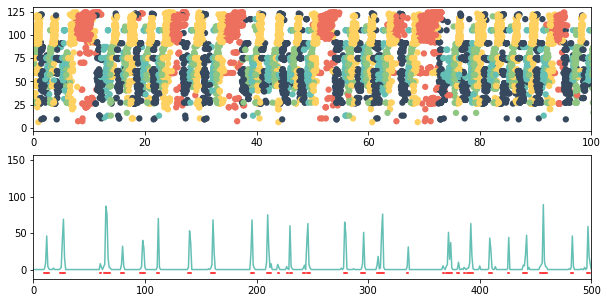

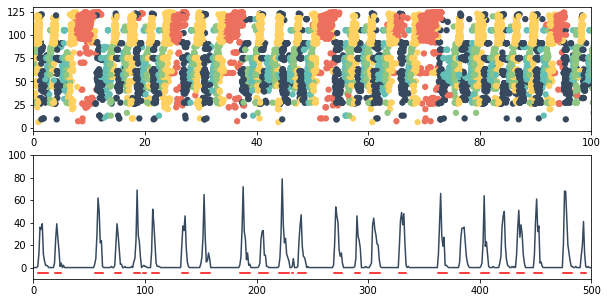

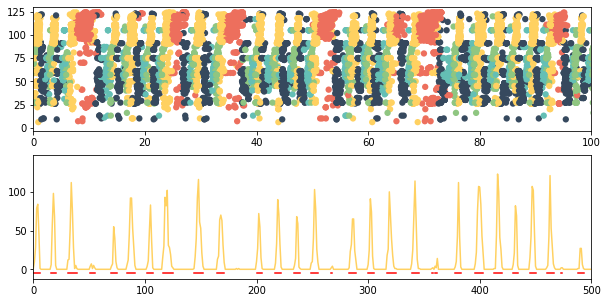

In [27]:
#### first define when seqs occur and label neurons that contribute to them 


seq_size_threshold= 5
    

unmasked_spikes_df = spikes_seq_type_adjusted
    
all_seq_neurons = []  
df_seq_inds = []
total_seqs_by_type =[]
seq_numbers_passed = []
current_order = []
all_mid_point_times = []
for i in range(1,7):
    if i-1 in logical_order:
        print(i)
        
        seq_spike_count = seq_spike_occurance[i]
        # find seq start and end, defined by whetehr there were spikes or not 
        groups = return_inds_for_seq_groups(seq_spike_count)

        ### plot to check that I am accounting ofr sequences properly

        #mask
        # spikemask
        timeframe = [0,800]
        mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
        background_remove_mask = unmasked_spikes_df[mask].sequence_type_adjusted >= 0
        c_ = np.array(colors)[unmasked_spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]

        fig,[ax1,ax2] = plt.subplots(2, 1,figsize=(10, 5))
        ax1.scatter(unmasked_spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=40, linewidth=0,color = c_ ,alpha=1)
        ax2.plot(seq_spike_count, color = colors[i])
        for item in groups:
            ax2.plot(item,[-5,-5], color = 'red')


        ax1.set_xlim([0,100])
        ax2.set_xlim([0,(100/bin_size)])

        seq_neurons = []
        df_index = []
        mid_point_time = []

        counter = 0
        for group in groups:

            # spikemask
            timeframe = [(group[0] * bin_size)-0.5,(group[-1] * bin_size)+0.5]
            mid_point_time += [timeframe[0] + (np.diff(timeframe)[0]/2)]
            mask = (unmasked_spikes_df.timestamp>timeframe[0])*(unmasked_spikes_df.timestamp<timeframe[-1])
            seq_mask = unmasked_spikes_df[mask].sequence_type_adjusted == i

            if len(unmasked_spikes_df[mask][seq_mask]) > seq_size_threshold:
                counter +=1
                seq_neurons.append(list(unmasked_spikes_df[mask][seq_mask].neuron))
                df_index += [list(unmasked_spikes_df[mask][seq_mask].index)]

        total_seqs_by_type += [counter]
        all_seq_neurons.append(seq_neurons)
        df_seq_inds.append(df_index)
        all_mid_point_times += [mid_point_time]
        
        current_order +=[i]

    
    

In [20]:
## determine number of sequences each neuron appears in 
neuron_id = []
percentage_breakdown = []
dominant_percentage = []
seqs_unique = []
dominant_seq = []
# loop across neurons 
for neuron_ in unmasked_spikes_df.neuron.unique():
    
    current_neuron_mask = unmasked_spikes_df.neuron == neuron_
    seq_type_appearances = unmasked_spikes_df[current_neuron_mask].sequence_type_adjusted.values.astype(int)

    #n percentage spikes that are background:
    len(seq_type_appearances[seq_type_appearances < 0])/len(seq_type_appearances)
    
    #percentage split across 
    background_remove = seq_type_appearances > 0
    seq_type_appearances[background_remove]

    seq_appearnce= []
    count = []
    
    # if not background:
    if not len(seq_type_appearances[background_remove]) == 0:     
        
        seqs_unique.append(list(np.unique(seq_type_appearances[background_remove])))
        for seq in np.unique(seq_type_appearances[background_remove]):
            seq_appearnce.append(seq)
            count.append(list(seq_type_appearances[background_remove]).count(seq))

        percentage_breakdown.append(calculate_percentages(count))
        dominant_percentage.append(max(calculate_percentages(count)))
        dominant_seq.append(np.unique(seq_type_appearances[background_remove])[np.argmax(calculate_percentages(count))])
        neuron_id.append(neuron_)

In [21]:
from tqdm import tqdm 
N_neurons= bkgd_log_proportions_array.shape[1]


# Iterate through the range
concat_data_rp = []
concat_data_o = []
for neuron in tqdm(range(N_neurons)):
    
    resp_prob_1 = []
    resp_prob_2 = []
    resp_prob_3 = []
    resp_prob_4 = []
    resp_prob_5 = []
    resp_prob_6 = []
    
    offset_1 = []
    offset_2 = []
    offset_3 = []
    offset_4 = []
    offset_5 = []
    offset_6 = []

    for iteration_ in range(400, 500):
        index_ = neuron + (N_neurons *  iteration_)
        current_data = neuron_response_df.loc[neuron_response_df.index == index_]
        resp_prob_1 += [float(current_data.x1)]
        resp_prob_2 += [float(current_data.x2)]
        resp_prob_3 += [float(current_data.x3)]
        resp_prob_4 += [float(current_data.x4)]
        resp_prob_5 += [float(current_data.x5)]
        resp_prob_6 += [float(current_data.x6)]
        
        offset_1 += [current_data.x7]
        offset_2 += [current_data.x8]
        offset_3 += [current_data.x9]
        offset_4 += [current_data.x10]
        offset_5 += [current_data.x11]
        offset_6 += [current_data.x12]
         
    new_row = [neuron+1,resp_prob_1,resp_prob_2,resp_prob_3,resp_prob_4,resp_prob_5,resp_prob_6]
    concat_data_rp.append(new_row)
    
    new_row = [neuron+1,offset_1,offset_2,offset_3,offset_4,offset_5,offset_6]
    concat_data_o.append(new_row)

resp_prop_df = pd.DataFrame(concat_data_rp, columns = ['neuron','response_prob_1','response_prob_2','response_prob_3','response_prob_4','response_prob_5','response_prob_6'])
offset_df = pd.DataFrame(concat_data_o, columns = ['neuron','offset_1','offset_2','offset_3','offset_4','offset_5','offset_6'])

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:06<00:00, 18.04it/s]


In [22]:
def calculate_mean_sem_of_neuron_seq_repsonses(resp_prop_df, var_arg ):

    all_mean_mean_resp_prop = []
    all_sem_mean_resp_prop = []
    all_index =[]

    for i_ in range(len(resp_prop_df)):
        row = resp_prop_df.loc[resp_prop_df.index == i_]

        mean_mean_resp_prop = []
        sem_mean_resp_prop = []
        for item in list(row)[1::]:
            if not var_arg == 'offset':
                resp_prop_unlog = np.exp(list(row[item])[0])
            else:
                resp_prop_unlog = list(row[item])[0]
            mean_mean_resp_prop += [np.mean(resp_prop_unlog)]
            if var_arg == 'offset':
                sem_mean_resp_prop += [scipy.stats.sem(resp_prop_unlog)[0]]
            else:
                sem_mean_resp_prop += [scipy.stats.sem(resp_prop_unlog)]

        all_mean_mean_resp_prop += [mean_mean_resp_prop]
        all_sem_mean_resp_prop += [sem_mean_resp_prop]
        all_index+=[i_]*len(mean_mean_resp_prop)

    return all_mean_mean_resp_prop,all_sem_mean_resp_prop,all_index

def calculate_mean_std_of_neuron_seq_repsonses(resp_prop_df, var_arg ):

    all_mean_mean_resp_prop = []
    all_sem_mean_resp_prop = []
    all_index =[]

    for i_ in range(len(resp_prop_df)):
        row = resp_prop_df.loc[resp_prop_df.index == i_]

        mean_mean_resp_prop = []
        sem_mean_resp_prop = []
        for item in list(row)[1::]:
            if not var_arg == 'offset':
                resp_prop_unlog = np.exp(list(row[item])[0])
            else:
                resp_prop_unlog = list(row[item])[0]
            mean_mean_resp_prop += [np.mean(resp_prop_unlog)]
            if var_arg == 'offset':
                sem_mean_resp_prop += [np.std(resp_prop_unlog)[0]]
            else:
                sem_mean_resp_prop += [np.std(resp_prop_unlog)]

        all_mean_mean_resp_prop += [mean_mean_resp_prop]
        all_sem_mean_resp_prop += [sem_mean_resp_prop]
        all_index+=[i_]*len(mean_mean_resp_prop)

    return all_mean_mean_resp_prop,all_sem_mean_resp_prop,all_index

all_mean_mean_resp_prop,all_std_mean_resp_prop,all_index_rp = calculate_mean_std_of_neuron_seq_repsonses(resp_prop_df,'resp_prop')
all_mean_mean_offset,all_sem_mean_offset,all_index_o = calculate_mean_sem_of_neuron_seq_repsonses(offset_df,'offset')

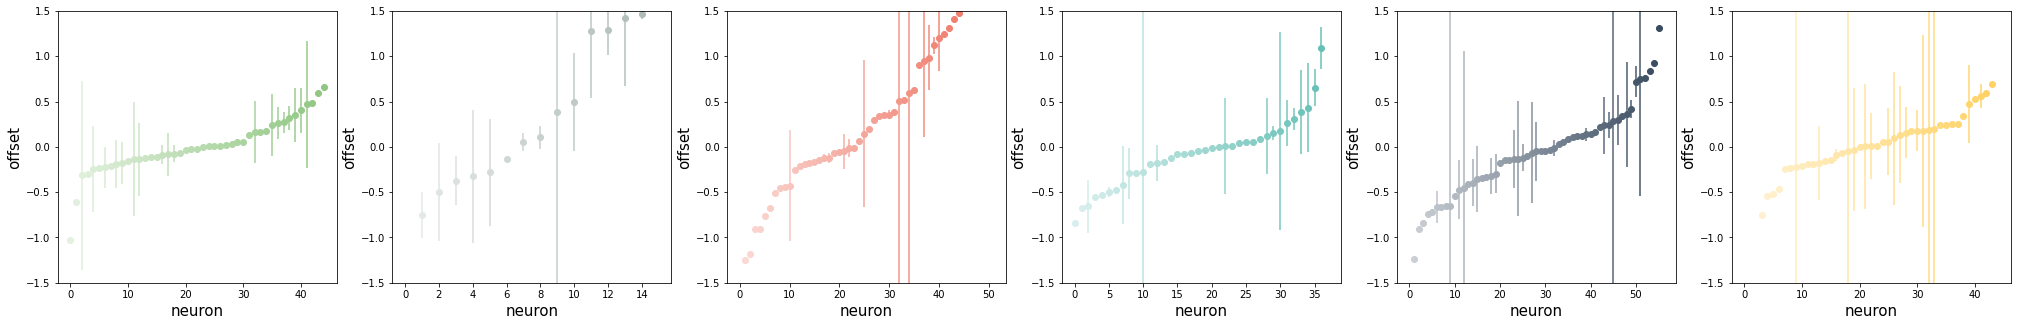

In [23]:
threshold = 10

import matplotlib.colors as mcolors

def create_color_gradient(start_color, end_color, num_samples):
    # Create a linear gradient between start_color and end_color
    gradient = np.linspace(0, 1, num_samples)

    # Create a color map using the start_color and end_color
    color_map = mcolors.LinearSegmentedColormap.from_list(
        'color_gradient', [start_color, end_color]
    )

    # Generate a list of colors from the color map
    colors = [color_map(gradient_value) for gradient_value in gradient]

    return colors

### for neurons that are actually involved in a sequence, what is their offset. ie. split by neurons that contribute at all (or at least over a threshold) to the seq - not just dominant ones 

nrow = 1 
ncol = 6
fig, axs = plt.subplots(nrow, ncol,figsize=(35, 5))

tot = 0
for index, ax in enumerate(fig.axes):
    seq = index + 1
    neuron_include  = []
    for index,neuron_seqs in enumerate(seqs_unique):
        if seq in neuron_seqs:
            p_occurance = percentage_breakdown[index][np.where(np.array(neuron_seqs) == seq)[0][0]]
            if p_occurance > threshold:
                neuron_include.append(index)
                
    offsets = np.array(all_mean_mean_offset)[np.array(neuron_include)][:,seq-1]
    e_bars = np.array(all_sem_mean_offset)[np.array(neuron_include)][:,seq-1]
#     ax.plot(sorted(offsets),'o', c = colors[seq])

    x = list(range(0,len(offsets)))
    y = sorted(offsets)
    
    tot+=len(x)
    
    color_gradient = create_color_gradient('white', colors[seq], len(x))
    intermediate_color = color_gradient[int(len(color_gradient) *0.25)]
    color_gradient = create_color_gradient(intermediate_color, colors[seq], len(x))
    
    for i in range(len(x)):
        ax.errorbar(x[i],y[i], yerr=e_bars[i], fmt='o', c = color_gradient[i])
    ax.set_ylim((-1.5,1.5))
    
    ax.set_ylabel('offset',size = 15)
    ax.set_xlabel('neuron',size = 15)

In [29]:
### order these by average distance between motifs? 
###### determine gaps between each:
def find_sequence(long_sequence, short_sequence):
    long_length = len(long_sequence)
    short_length = len(short_sequence)  
    occurrences = []
    for i in range(long_length - short_length + 1):
        if long_sequence[i:i+short_length] == short_sequence:
            occurrences.append(i)
    return occurrences

threshold = 2 #seconds

combined_events = []
seq_type_labels = []
for index,events in enumerate(all_mid_point_times):
    combined_events += events
    seq_type_labels += [np.array(sorted(logical_order))[index]]*len(events)
    
sorted_events = list(np.array(combined_events)[np.argsort(combined_events)])
sorted_labels = list(np.array(seq_type_labels)[np.argsort(combined_events)])

all_gaps = []
for e in range(len(logical_order)-1):
    print(e)
    occurance_inds = find_sequence(sorted_labels,[logical_order[e],logical_order[e+1]])

    gap = []
    for i in range(len(occurance_inds)):
        current_gap = np.diff(sorted_events[occurance_inds[i]:occurance_inds[i]+2])[0]
        if current_gap < threshold:
            gap += [current_gap]
    all_gaps += [gap]
    
gap_means = []
for gap in all_gaps:
    gap_means += [np.mean(gap)]

0
1
2
3


111
111
111
111


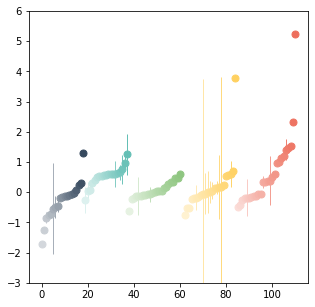

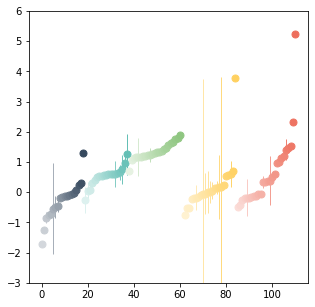

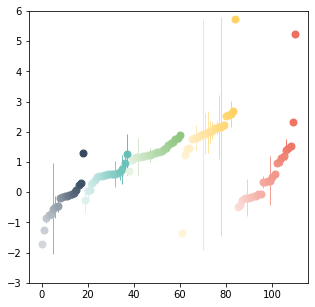

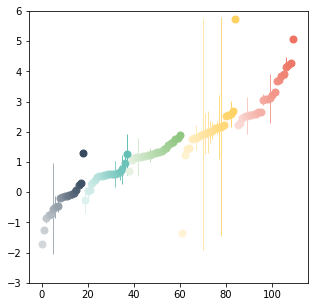

In [30]:


all_offsets = []
all_colors = []
all_e_bars = []

for index in range(6):
    seq = index + 1
    neuron_include  = []
    for index,neuron_seqs in enumerate(seqs_unique):
        if seq in neuron_seqs:
            p_occurance = percentage_breakdown[index][np.where(np.array(neuron_seqs) == seq)[0][0]]
            if p_occurance > threshold:
                current_neuron = neuron_id[index]
                if current_neuron in list(np.array(neuron_id)[np.array(dominant_seq) == seq]):
                    neuron_include.append(index)
                
    offsets = np.array(all_mean_mean_offset)[np.array(neuron_include)][:,seq-1]
    e_bars = np.array(all_sem_mean_offset)[np.array(neuron_include)][:,seq-1]
#     ax.plot(sorted(offsets),'o', c = colors[seq])

    x = list(range(0,len(offsets)))
    y = sorted(offsets)
    
    color_gradient = create_color_gradient('white', colors[seq], len(x))
    intermediate_color = color_gradient[int(len(color_gradient) *0.25)]
    color_gradient = create_color_gradient(intermediate_color, colors[seq], len(x))
    
    all_offsets+=[y]
    all_colors+=[color_gradient]
    all_e_bars += [e_bars]
    
def reorder_lists(original_list, index_list):
    return [original_list[i] for i in index_list]

def add_missing_numbers(lst, start_num, end_num):
    new_lst = lst.copy()
    missing_numbers = [num for num in range(start_num, end_num+1) if num not in lst]
    new_lst += missing_numbers
    return new_lst,len(missing_numbers)



new_order, missing_count = add_missing_numbers(logical_order, 0, 5)

new_order = np.array([4, 3, 0, 5, 2,1])

reordered_all_offsets = reorder_lists(all_offsets,new_order)
reordered_all_e_bars = reorder_lists(all_e_bars,new_order)
reordered_all_all_colors = reorder_lists(all_colors,new_order)

## add in gaps
for i in range(len(np.cumsum(gap_means))):
    reordered_all_offsets[i+1] = list(np.array(reordered_all_offsets[i+1]) + np.cumsum(gap_means)[i])

    flat_offsets = [item for sublist in reordered_all_offsets[0:-missing_count] for item in sublist]
    flat_e_bars = [item for sublist in reordered_all_e_bars[0:-missing_count] for item in sublist]
    flat_colors_grads = [item for sublist in reordered_all_all_colors[0:-missing_count] for item in sublist]
    x = np.linspace(0 ,len(flat_offsets)-1,len(flat_offsets))
    
    print(len(x))



    fig, ax = plt.subplots(1, 1,figsize=(5, 5))
    for i,y in enumerate(flat_offsets):
        ax.errorbar(x[i],y, yerr=flat_e_bars[i], fmt='o', c = flat_colors_grads[i],markersize = 7, linewidth = 1)
    ax.set_ylim(-3,6)

# SaveFig('temporal_order_ordered.png',save_path)
# SaveFig('temporal_order_ordered.pdf',r'Z:\projects\Emmett\Documents\writeup\fig4_PPseq\\')


In [31]:
PP_PATH = r"Z:\projects\sequence_squad\organised_data\ppseq_data\finalised_output\striatum\awake\\"
## set ppseq file
dominance_a_a = []
Num_seqs_neurons_appeared_in_a_a = []
seq_involvement_prop_a_a = []
non_neighbor_proportions_a_a = []
neighbor_proportions_a_a = []

for file_ in os.listdir(PP_PATH):
    if 'run' in file_:
        current_path = PP_PATH + file_ + r"\analysis_output\\latent_composition_analysis\\"
        if os.path.isdir(current_path):
            dominance_a_a += [list(np.load(current_path + 'dominance.npy'))] 
            print(file_)
            Num_seqs_neurons_appeared_in_a_a += [list(np.load(current_path + 'Num_seqs_neurons_appeared_in.npy'))] 
            seq_involvement_prop_a_a += list(np.load(current_path + 'seq_involvement_prop.npy'))
            try:
                non_neighbor_proportions_a_a += [list(np.load(current_path + 'non_neighbor_proportions.npy'))]  
                neighbor_proportions_a_a += [list(np.load(current_path + 'neighbor_proportions.npy'))]
            except:
                print('no neighbours ' + file_)

    

136_1_3_run_2701023_1835
136_1_4_run_2701023_1813
148_2_2_run_2701023_1717
149_1_1_run_2701023_2100
149_1_2_run_2701023_1856
162_1_3_run_2701023_2241
178_1_4_run_2701023_2020
178_1_5_run_2701023_1657
178_1_6_run_2701023_1750
178_1_7_run_2701023_1720
178_1_8_run_2701023_1641
178_1_9_run_2701023_1748
178_2_1_run_2701023_2006
178_2_2_run_2701023_1728
178_2_3_run_2701023_1532
178_2_4_run_0102023_0016
268_1_10_run_0606023_0235
no neighbours 268_1_10_run_0606023_0235
269_1_7_run_0606023_0216
270_1_5_run_0606023_0208


(0.0, 1.0)

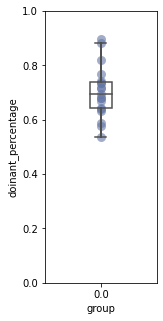

In [32]:
### donimant proportion 

fig,ax= plt.subplots(1, 1,figsize=(2, 5))
means = []
for list_doms in dominance_a_a:
    means += [np.mean(list_doms)]
ax.plot(np.zeros(len(means)),means,'o',color = '#6275A5', markersize = 9,alpha = 0.6, markeredgewidth=0.0)

plot_df = pd.DataFrame({'group': np.zeros(len(means)), 'doinant_percentage': means}, )

ax=sns.boxplot( y = 'doinant_percentage', x = 'group', data = plot_df, color = '#6275A5', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)
ax.set_ylim(0,1)


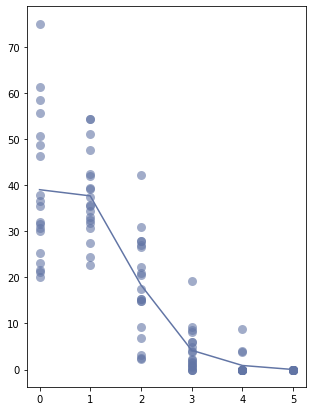

In [33]:
# plot number of sequences neurons appear in as percentage of spikes
means = []
fig,ax= plt.subplots(1, 1,figsize=(5, 7))
for index,item in enumerate(conactinate_nth_items(Num_seqs_neurons_appeared_in_a_a)):
    ax.plot([index]*len(item),item,'o', color = '#6275A5', markersize = 9,alpha = 0.6, markeredgewidth=0.0)#
    means += [np.mean(item)]
ax.plot(means,'-', color = '#6275A5')


NormaltestResult(statistic=2.29075873181206, pvalue=0.31810321738178354)
NormaltestResult(statistic=4.69485237281457, pvalue=0.09561494082006201)
both greater than 0.05 = normally distributed, so paired t test used
TtestResult(statistic=-2.4272900747507284, pvalue=0.027388204081063117, df=16)


C:\Users\EJThompson\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\EJThompson\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\EJThompson\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


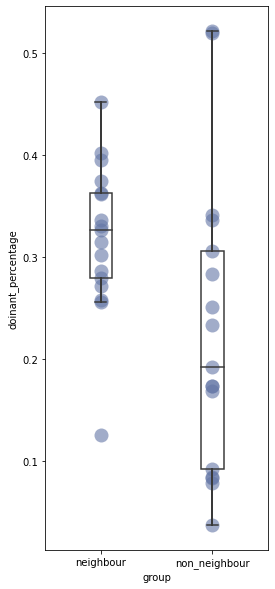

In [34]:
non_neighbor_means = []
neighbor_means = []
for index,item in enumerate(non_neighbor_proportions_a_a):
    non_neighbor_means += [np.mean(item)]
    neighbor_means += [np.mean(neighbor_proportions_a_a[index])]

#remove nan value:
non_neighbor_means =non_neighbor_means[0:12] + non_neighbor_means[13::]
neighbor_means= neighbor_means[0:12] + neighbor_means[13::]

fig,ax= plt.subplots(1, 1,figsize=(4, 10))
ax.plot(np.ones(len(non_neighbor_means)),non_neighbor_means,'o',color = '#6275A5', markersize = 14,alpha = 0.6, markeredgewidth=0.0 )


ax.plot(np.zeros(len(neighbor_means)),neighbor_means,'o',color = '#6275A5', markersize = 14,alpha = 0.6, markeredgewidth=0.0 )

plot_df = pd.DataFrame({'group': (['neighbour']*len(neighbor_means)) + (['non_neighbour']*len(non_neighbor_means)), 'doinant_percentage': neighbor_means+non_neighbor_means})

ax=sns.boxplot( y = 'doinant_percentage', x = 'group', data = plot_df, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

print(scipy.stats.normaltest(non_neighbor_means))
print(scipy.stats.normaltest(neighbor_means))
print('both greater than 0.05 = normally distributed, so paired t test used')
print(scipy.stats.ttest_rel(non_neighbor_means, neighbor_means))
